In [1]:
# %tensorflow_version 2.x
# from tqdm import tqdm
import tensorflow as tf

In [ ]:
!wget https://www.cs.ucsb.edu/~william/data/liar_dataset.zip -q --show-progress
!unzip 'liar_dataset.zip' -d LIAR_dataset
!wget https://raw.githubusercontent.com/saurav9878/Fake-News-Detection/master/Clean_Texts.py -q --show-progress
!wget https://raw.githubusercontent.com/saurav9878/Fake-News-Detection/master/AttentionLayer.py -q --show-progress
!mkdir plots

In [2]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
import sys
import os
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Activation, LSTM, GRU, Bidirectional, TimeDistributed, BatchNormalization, Dropout
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
#from keras.layers import Merge
#replaced by
from keras.layers import add

# NLTK import, download
import nltk
from nltk import tokenize # used only for splitting data into words, sentences
nltk.download(['punkt', 'stopwords'], quiet=True)

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [4]:
#import my modules
from Clean_Texts import clean_text
from AttentionLayer import AttLayer

In [5]:
def read_data(filename):
    df = pd.read_csv(filename,engine='python', delimiter=r'\t+', names=['id', 'Label','Statement', 'subject', 'speaker','speaker_title','state', 'party','barely_true','false_counts','half_true','mostly_true','pants_on_fire','context'])
    labels=[]
    for l in df['Label']:
        if l in ['false','barely-true','pants-fire']:
            labels.append(1)
        elif l in ['half-true','mostly-true', 'true']:
            labels.append(0)
        else:
            raise Exception("Error encountered in labelling")
    data = pd.concat([df['Statement'], pd.Series(labels)], axis=1)
    data.columns = ['Statement', 'Label']
    return data

In [6]:
data_train = read_data('LIAR_dataset/train.tsv')
data_test = read_data('LIAR_dataset/test.tsv')
data_valid = read_data('LIAR_dataset/valid.tsv')
data_train = pd.concat([data_train, data_valid])


train_labels = np.asarray(data_train['Label'])
test_labels = np.asarray(data_test['Label'])

In [ ]:
y_tr = [sum(train_labels), len(train_labels) - sum(train_labels)]
x_tr = ["Fake", "Not Fake"]
plt.figure(figsize=(8,8))
plt.bar(x_tr,y_tr)
for i in range(2):
    plt.text(x_tr[i], y_tr[i]+60, str(y_tr[i]),ha='center', color='blue', fontsize=18)
plt.ylim(top=7000)
plt.xlabel('Class')
plt.ylabel('No. of samples')
plt.title('Training class distribution')
plt.rcParams.update({'font.size': 21})
plt.savefig('plots/train_class_dist.png')

In [ ]:
y_tr = [sum(test_labels), len(test_labels) - sum(test_labels)]
x_tr = ["Fake", "Not Fake"]
plt.figure(figsize=(8,8))
plt.bar(x_tr,y_tr)
for i in range(2):
    plt.text(x_tr[i], y_tr[i]+30, str(y_tr[i]),ha='center', color='blue', fontsize=18)
plt.ylim(top=850)
plt.xlabel('Class')
plt.ylabel('No. of samples')
plt.title('Test class distribution')
plt.rcParams.update({'font.size': 18})
plt.savefig('plots/test_class_dist.png')

In [7]:
# ! pip install transformers
import transformers
dbert_tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased',)
dbert_model = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
# small_train = data_train.Statement.iloc[:10]
# train_tokenized = data_train.Statement.apply((lambda x: dbert_tokenizer.encode(x, add_special_tokens=True, max_length=128, padding='max_length')))
train_tokenized = data_train.Statement.apply((lambda x: dbert_tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
test_tokenized = data_test.Statement.apply((lambda x: dbert_tokenizer.encode(x, add_special_tokens=True)))

Masking

In [ ]:
max_len = 0
for i in train_tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in train_tokenized.values])

In [ ]:
max_len = 98
for i in test_tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

test_padded = np.array([i + [0]*(max_len-len(i)) for i in test_tokenized.values])

In [ ]:
print('Shape of features after padding: ' + str(padded.shape))

Masking to ignore 0's for distilbert else it'll get confused

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)

In [ ]:
import torch

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = dbert_model(input_ids, attention_mask=attention_mask)

In [ ]:
import h5py

In [ ]:
last_hidden_states[0].shape

In [ ]:
with h5py.File('./LIAR_dataset/test_clf_features.hdf5', 'w') as f:
    dset = f.create_dataset('default', data = last_hidden_states[0][:,0,:].numpy())

In [8]:
import h5py

In [9]:
with h5py.File('./LIAR_dataset/hidden_features.hdf5', 'r') as f:
    train_data = f.get('default').value
with h5py.File('./LIAR_dataset/test_features.hdf5', 'r') as g:
    test_data = g.get('default').value

In [ ]:
clf_features = data

In [ ]:
clf_features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
features.shape

In [ ]:
full_features = last_hidden_states[0].numpy()

In [ ]:
# input_tokens=[]
# for x in train_tokenized:
#     input_tokens.append(x)

# input_tokens = np.asarray(input_tokens)
# print('Input tokens shape:')
# print(input_tokens.shape)
# print('--------------------')

In [ ]:
# output_tokens = dbert_model(input_tokens)

In [ ]:
# from transformers import pipeline
# feature_pipeline = pipeline('feature-extraction', model=dbert_model, tokenizer=dbert_tokenizer(max_length=20, add_special_tokens=True,padding='max-length'), framework='tf')

In [ ]:
# import numpy as np
# np.asarray(feature_pipeline('Hello World', max_length =2)).shape

In [ ]:
# feature_extracted = feature_pipeline(list(data_train.Statement)[:10])

In [ ]:
# test_tokenized = data_test.Statement.apply((lambda x: dbert_tokenizer.encode(x, add_special_tokens=True, max_length=128, padding='max_length')))
# input_test_tokens=[]
# for x in test_tokenized:
#     input_test_tokens.append(x)

# input_test_tokens = np.asarray(input_test_tokens)

# test_features = dbert_model(input_test_tokens)

In [ ]:
# test_features = np.asarray(test_features)


In [ ]:
# features_array = np.asarray(feature_extracted)
# print('Features array shape:')
# print(features_array.shape) # (Samples, Tokens, Vector Size)
# print('---------------------')

In [ ]:
# MAX_TOKENS = 128

In [ ]:
# features = np.squeeze(features_array)
# features = features[:,0,:]
# features.shape

In [ ]:
# import tensorflow as tf

In [17]:
# labels = train_labels[:10]
labels = train_labels.reshape(-1,1)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(train_data, labels)

In [18]:
#full_features
train_features, valid_features, train_labels, valid_labels = train_test_split(train_data, labels)

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

In [ ]:
lr_score = lr_clf.score(va_features, test_labels)
print('Accuracy achieved by Logistic Regression: ' + str(lr_score*100) + '%')

## Accuracy achieved by Logistic Regression: 61.509172724125996%

In [10]:
#customized f1 score function for passing into model metrics:
def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
import tensorflow as tf

In [12]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [77]:
# tf.debugging.set_log_device_placement(True)

# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
#     model = Sequential([
#         Input(shape=(98,768,), dtype='float32'),
#         Conv1D(filters=100,kernel_size=3,padding='valid'),
#         BatchNormalization(),
#         Activation('relu'),
#         MaxPooling1D(pool_size=2),
#         Bidirectional(GRU(100, return_sequences=True)),
#         AttLayer(100),
#         Dropout(0.2),
#         Dense(1, activation='sigmoid')
#   ])
#     model.compile(loss='binary_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy',F1_Score,])

embedded_sequences = Input(shape=(98,768,), dtype='float32')
c=Conv1D(filters=8,kernel_size=3,padding='valid')(embedded_sequences)
bn = BatchNormalization()(c)
actv = Activation('relu')(bn)
maxPool = MaxPooling1D(pool_size=2)(actv)
l_lstm = Bidirectional( GRU(100, return_sequences=True))(maxPool)
l_att = AttLayer(100)(l_lstm)
drp = Dropout(0.5)(l_att)
preds = Dense(1, activation='sigmoid')(drp)
model_Att = Model(embedded_sequences, preds)
model_Att.summary()

# from keras.utils.vis_utils import plot_model
# plot_model(model_Att, to_file='plots/model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

model_Att.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',F1_Score,])
K.set_value(model_Att.optimizer.learning_rate, 0.00025)


# score=model_Att.evaluate(x_test,y_test,verbose=1)
# print('Test Accuracy: '+str(score[1]))
# print('Test F1 Score: '+str(score[2]))

# from sklearn.metrics import precision_recall_fscore_support,classification_report
# y_pred=model_Att.predict(x_test)
# #print(y_pred)
# y2=[]
# for q in y_pred:
#   if(q[0]>0.5):
#     y2.append(True)
#   else:
#     y2.append(False)
# print('Classification report:\n',classification_report(y_test,y2))
# #print('Classification report:\n',precision_recall_fscore_support(y_test,y_pred))
# #print(y_pred)

tracking <tf.Variable 'att_layer_7/Variable:0' shape=(200, 100) dtype=float32> W
tracking <tf.Variable 'att_layer_7/Variable:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'att_layer_7/Variable:0' shape=(100, 1) dtype=float32> u
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 98, 768)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 96, 8)             18440     
_________________________________________________________________
batch_normalization_7 (Batch (None, 96, 8)             32        
_________________________________________________________________
activation_7 (Activation)    (None, 96, 8)             0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 48, 8)             0         
____________________

In [78]:
from keras.callbacks import EarlyStopping


In [79]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=3, verbose=1)

In [80]:
history = model_Att.fit(train_features, train_labels, validation_data=(valid_features, valid_labels),
          epochs=20, batch_size=32, callbacks=[es])

Train on 8664 samples, validate on 2889 samples
Epoch 1/20
8664/8664 [==============================] - 35s 4ms/step - loss: 0.6700 - accuracy: 0.5840 - F1_Score: 0.4432 - val_loss: 0.6519 - val_accuracy: 0.6213 - val_F1_Score: 0.4635
Epoch 2/20
8664/8664 [==============================] - 33s 4ms/step - loss: 0.6543 - accuracy: 0.6125 - F1_Score: 0.5345 - val_loss: 0.6460 - val_accuracy: 0.6248 - val_F1_Score: 0.4705
Epoch 3/20
8664/8664 [==============================] - 34s 4ms/step - loss: 0.6437 - accuracy: 0.6309 - F1_Score: 0.5536 - val_loss: 0.6450 - val_accuracy: 0.6203 - val_F1_Score: 0.4580
Epoch 4/20
8664/8664 [==============================] - 34s 4ms/step - loss: 0.6368 - accuracy: 0.6413 - F1_Score: 0.5719 - val_loss: 0.6496 - val_accuracy: 0.6199 - val_F1_Score: 0.4987
Epoch 5/20
8664/8664 [==============================] - 34s 4ms/step - loss: 0.6297 - accuracy: 0.6484 - F1_Score: 0.5662 - val_loss: 0.6542 - val_accuracy: 0.6154 - val_F1_Score: 0.5563
Epoch 6/20
8664/8

In [81]:
score=model_Att.evaluate(test_data,test_labels,verbose=1)
print('Test Accuracy: '+str(score[1]))
print('Test F1 Score: '+str(score[2]))

from sklearn.metrics import precision_recall_fscore_support,classification_report
y_pred=model_Att.predict(test_data)
#print(y_pred)
y2=[]
for q in y_pred:
    if(q[0]>0.5):
        y2.append(True)
    else:
        y2.append(False)
print('Classification report:\n',classification_report(test_labels,y2))
#print('Classification report:\n',precision_recall_fscore_support(y_test,y_pred))
#print(y_pred)

1283/1283 [==============================] - 2s 1ms/step
Test Accuracy: 0.6134060621261597
Test F1 Score: 0.5935375690460205
Classification report:
               precision    recall  f1-score   support

           0       0.68      0.59      0.63       727
           1       0.55      0.64      0.59       556

   micro avg       0.61      0.61      0.61      1283
   macro avg       0.61      0.62      0.61      1283
weighted avg       0.62      0.61      0.62      1283



In [82]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y2)
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[430 297]
 [199 357]]


dict_keys(['val_loss', 'val_accuracy', 'val_F1_Score', 'loss', 'accuracy', 'F1_Score'])


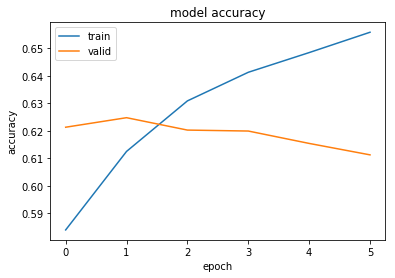

In [83]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
# plt.show()
plt.savefig('plots/Model_accuracy.png')

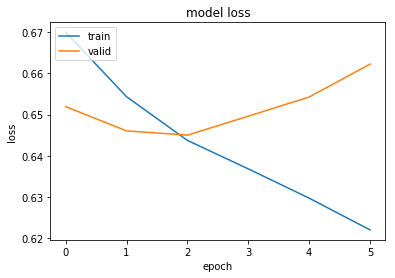

In [84]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
# plt.show()
plt.savefig('plots/Model_loss.png')